# Steam Review Classification Model

In [ ]:
from IPython.display import clear_output 

!pip install transformers==4.8.2
!pip install sentencepiece==0.1.96 # 이번 실습에서 추가되었습니다
!pip install tensorflow_addons

clear_output() # clear the output after the installation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import pickle 
import dill # for saving a function as a file(.pkl)
import logging # for changing the tf's logging level
import urllib.request
from tqdm import tqdm

from sklearn import model_selection
from sklearn.metrics import accuracy_score

import tensorflow as tf
import tensorflow_addons as tfa # for using Rectified-Adam optimizer (instead of Adam optimizer) 
from tensorflow.keras import layers, initializers, losses, optimizers, metrics, callbacks 

import transformers
from transformers import BertTokenizerFast, TFBertModel

import sentencepiece as spm # 이번 실습에서 추가되었습니다

In [ ]:
# Random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

# Transformers logging level 변경 (WARNING -> ERROR) @ https://huggingface.co/transformers/main_classes/logging.html
transformers.logging.set_verbosity(transformers.logging.ERROR)

# Tensorflow logging level 변경 
tf.get_logger().setLevel(logging.ERROR)

## Load data and drop duplicated

In [ ]:
# download dataset to github
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam_review.txt")

# load data
reviews_df = pd.read_table('steam_review.txt', names=['label', 'reviews'])
# drop duplicate
steam_df = reviews_df.drop_duplicates('reviews').reset_index(drop=True) # drop 118 row
steam_df

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요
...,...,...
99887,0,한글화해주면 10개산다
99888,0,개쌉노잼 ㅋㅋ
99889,0,노잼이네요... 30분하고 지웠어요...
99890,1,야생을 사랑하는 사람들을 위한 짧지만 여운이 남는 이야기. 영어는 그리 어렵지 않습니다.


In [ ]:
# 추가 학습 1 (네이버 영화 리뷰)
# download dataset to github
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="naver_movie_review.txt")

# load data
naver_movie_df = pd.read_table('naver_movie_review.txt')
naver_movie_df = naver_movie_df[['document', 'label']].rename(columns={'document': 'reviews'})
naver_movie_df
# drop duplicate
naver_movie_df = naver_movie_df.drop_duplicates('reviews').reset_index(drop=True) # drop 118 row
naver_movie_df

,reviews,label
0,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1
...,...,...
194539,포켓 몬스터 짜가 ㅡㅡ;;,0
194540,쓰.레.기,0
194541,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.,0
194542,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0


In [ ]:
# 추가 학습 2 (네이버 쇼핑 리뷰)
# download dataset to github
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="naver_shopping_review.txt")

# load data
naver_shopping_df = pd.read_table('naver_shopping_review.txt', names=['score', 'reviews'])
naver_shopping_df['label'] = naver_shopping_df['score'].apply(lambda x: 1 if x > 3 else 0)
naver_shopping_df = naver_shopping_df[['reviews', 'label']]

# drop duplicate
naver_shopping_df = naver_shopping_df.drop_duplicates('reviews').reset_index(drop=True)
naver_shopping_df

,reviews,label
0,배공빠르고 굿,1
1,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1
...,...,...
199903,장마라그런가!!! 달지않아요,0
199904,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...,1
199905,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요,1
199906,넘이쁘고 쎄련되보이네요~,1


### Concatenate tables

In [ ]:
reviews_df = pd.concat([steam_df, naver_movie_df, naver_shopping_df], axis=0).reset_index(drop=True)
reviews_df

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요
...,...,...
494339,0,장마라그런가!!! 달지않아요
494340,1,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...
494341,1,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요
494342,1,넘이쁘고 쎄련되보이네요~


In [ ]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494344 entries, 0 to 494343
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   label    494344 non-null  int64 
 1   reviews  494343 non-null  object
dtypes: int64(1), object(1)
memory usage: 7.5+ MB


In [ ]:
# 결측값 제거
reviews_df = reviews_df.drop(index=reviews_df[reviews_df['reviews'].isna()].index).reset_index(drop=True)
reviews_df

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요
...,...,...
494338,0,장마라그런가!!! 달지않아요
494339,1,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...
494340,1,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요
494341,1,넘이쁘고 쎄련되보이네요~


### Max length check

Using by KoBERT

In [ ]:
!git clone https://github.com/monologg/KoBERT-Transformers.git # 코버트 사용 시
clear_output() # clear the output

In [ ]:
!mv KoBERT-Transformers/kobert_transformers/tokenization_kobert.py /content

mv: cannot stat 'KoBERT-Transformers/kobert_transformers/tokenization_kobert.py': No such file or directory


In [ ]:
from tokenization_kobert import KoBertTokenizer

# tokenizer = BertTokenizerFast.from_pretrained('kykim/bert-kor-base', cache_dir='bert_ckpt', do_lower_case=False)
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert') # sentencepiece 라이브러리가 먼저 import 되어있어야 합니다.
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', cache_dir='bert_ckpt', do_lower_case=False) 

In [ ]:
# print KoBERT dictionary
print(tokenizer.get_vocab()) # '[PAD]' token이 '0'이 아닌 '1'로 지정되어 있습니다.

{'[UNK]': 0, '[PAD]': 1, '[CLS]': 2, '[SEP]': 3, '[MASK]': 4, '!': 5, "!'": 6, '!”': 7, '"': 8, '#': 9, '$': 10, '%': 11, '%)': 12, '&': 13, '&#34;': 14, "'": 15, "'(": 16, "',": 17, '(': 18, '(0': 19, '(1': 20, '(10': 21, '(12': 22, '(15': 23, '(17': 24, '(18': 25, '(19': 26, '(2': 27, '(20': 28, '(23': 29, '(24': 30, '(25': 31, '(3': 32, '(4': 33, '(5': 34, '(6': 35, '(7': 36, '(8': 37, '(9': 38, '(?)': 39, ')': 40, ")'": 41, '),': 42, ')’': 43, '*': 44, '+': 45, ',': 46, '-': 47, '----------------': 48, '-1': 49, '-2': 50, '-20': 51, '-3': 52, '-4': 53, '.': 54, '...': 55, '..."': 56, "...'": 57, '...”': 58, '/': 59, '0': 60, '0%': 61, '0%)': 62, '0.0': 63, '0.00': 64, '0.1': 65, '0.1%': 66, '0.2%': 67, '0.3': 68, '0.3%': 69, '0.4%': 70, '0.5': 71, '0.5%': 72, '0.6': 73, '0.6%': 74, '0.7': 75, '0.7%': 76, '0.8': 77, '0.8%': 78, '00': 79, '000.0': 80, '00000': 81, '01': 82, '02': 83, '02-': 84, '03': 85, '04': 86, '05': 87, '06': 88, '07': 89, '08': 90, '09': 91, '0:00:00': 92, '1': 

In [ ]:
# 가장 길이가 긴 리뷰의 행 번호 & 글자 개수
reviews_df['reviews'].str.len().sort_values(ascending=False)[:5] 

173473    142
137855    140
76193     140
23691     140
65191     140
Name: reviews, dtype: int64

In [ ]:
reviews_df['reviews'][173474]

'도대체 왜 재미없다고들하시지. 전 진짜 너무 재미있게봤어요.'

In [ ]:
# 가장 길이가 긴 리뷰를 tokenizing하여 얻어진 token 개수
len(tokenizer.tokenize(reviews_df['reviews'][173474]))

22

In [ ]:
SEQ_LEN = 128 # 최대 token 개수 이상의 값으로 임의로 설정
# 위 SEQ_LEN 값은 실제 적용할 텍스트데이터의 형태에 따라 증감합니다. 너무 큰 값을 지정할 경우 메모리가 부족할 수 있으며, 그러한 경우에는 길이가 긴 텍스트를 문장 단위 등으로 더 나눠 활용합니다.
len(tokenizer.encode("사전 학습된 토크나이저에 대한 테스트입니다.", max_length=SEQ_LEN, padding='max_length'))

128

In [ ]:
result = tokenizer.encode_plus('와....스토리와 그때 당시 깔끔했던 그래픽 독특한 레벨구성등 장점이 너무 많습니다.단점이라면 버그가 다른게임에 비해 많은편이고전투가 너무 단조롭고,마지막 보스는 너무 쉽고 그리고 일자형 구성이라 짧은 플탐....그래도 명작은 어디 안가니 추천합니다.', max_length=128, padding='max_length')
result

# 'input_ids', 'token_type_ids', 'attention_mask' 3가지 key를 갖고 있는 dict를 return 합니다.

{'input_ids': [2, 517, 6983, 54, 55, 6689, 6983, 1194, 1626, 1340, 5646, 7872, 1196, 1729, 1884, 6349, 5495, 6573, 5944, 3966, 7096, 1458, 517, 6158, 6701, 54, 5788, 7224, 6009, 2302, 5538, 5330, 1567, 5401, 6896, 2544, 1955, 7720, 7096, 5439, 7207, 7641, 5330, 1458, 1585, 7253, 6087, 5439, 46, 6141, 7318, 6149, 2355, 6666, 1458, 517, 6657, 5439, 1210, 3803, 7147, 7921, 1120, 7101, 4397, 517, 7761, 7593, 54, 55, 5540, 5859, 2034, 7170, 7086, 3223, 3135, 5330, 5770, 4559, 7843, 54, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Data preprocessing

In [ ]:
# params_data.py
SEQ_LEN = 128 # 최대 token 개수 이상의 값으로 임의로 설정

In [ ]:
reviews_df['reviews'].to_numpy()

array(['노래가 너무 적음', '돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다.',
       '막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지', ...,
       '로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요', '넘이쁘고 쎄련되보이네요~',
       '아직 사용해보지도않았고 다른 제품을 써본적이없어서 잘 모르겠지만 ㅎㅎ 배송은 빨랐습니다'], dtype=object)

In [ ]:
train_data, test_data, train_label, test_label = model_selection.train_test_split(reviews_df['reviews'], reviews_df['label'], 
                                                                    test_size=0.05, 
                                                                    random_state=42)
print(train_data.shape)
print(test_data.shape)

(469625,)
(24718,)


In [ ]:
def text_preprocessing(data_series, label_series):
    
    token_ids = []
    token_masks = []
    token_segments = []

    labels = []

    for idx in tqdm(range(len(data_series))):

        sentence = data_series.iloc[idx]
        

        # 특수문자 제거
        cleaned_sentence = re.sub("[^\s0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣]", "", sentence) # [ whitespaces, 숫자, 영문 알파벳, 한글(+자모음) ]이 아닌 것을 공백으로 치환 (특수문자 제거)


        # Tokenizing / Tokens to sequence numbers / Padding
        encoded_dict = tokenizer.encode_plus(text=cleaned_sentence, 
                                            padding='max_length', 
                                            truncation=True, 
                                            max_length=SEQ_LEN)
      
        token_ids.append(encoded_dict['input_ids']) # tokens_tensor
        token_masks.append(encoded_dict['attention_mask']) # masks_tensor
        token_segments.append(encoded_dict['token_type_ids']) # segments_tensor

        labels.append(label_series.iloc[idx])
        
    
    data_inputs = (np.array(token_ids), np.array(token_masks), np.array(token_segments))
    data_labels = np.array(labels)
    
    return data_inputs, data_labels


In [ ]:
train_inputs, train_labels = text_preprocessing(train_data, train_label)

100%|██████████| 469625/469625 [02:16<00:00, 3436.82it/s]


## Building model

In [ ]:
def create_model():

    # bert_base_model = TFBertModel.from_pretrained("kykim/bert-kor-base", cache_dir='bert_ckpt', from_pt=True) 
    bert_base_model = TFBertModel.from_pretrained("monologg/kobert", cache_dir='bert_ckpt', from_pt=True) 
    input_token_ids = layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_token_ids')   # tokens_tensor
    input_masks     = layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')       # masks_tensor
    input_segments  = layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segments')    # segments_tensor  

    bert_outputs = bert_base_model([input_token_ids, input_masks, input_segments]) 
    # bert_outputs -> 0: 'last_hidden_state' & 1: 'pooler_output' (== applied GlobalAveragePooling1D on 'last_hidden_state')

    bert_outputs = bert_outputs[1] # ('pooler_output', <KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf_bert_model')>)
    bert_outputs = layers.Dropout(0.3)(bert_outputs)
    final_output = layers.Dense(units=2, activation='softmax', kernel_initializer=initializers.TruncatedNormal(stddev=0.02), name="classifier")(bert_outputs)

    model = tf.keras.Model(inputs=[input_token_ids, input_masks, input_segments], 
                        outputs=final_output)

    # RAdam (Rectified-Adam) @ http://j.mp/2P5OmF3 / http://j.mp/2qzRjUa / http://j.mp/2N322hu / http://j.mp/2MYtPQ2
    model.compile(optimizer=tfa.optimizers.RectifiedAdam(learning_rate=1e-5, weight_decay=0.0025, warmup_proportion=0.05),
                  loss=losses.SparseCategoricalCrossentropy(), 
                  metrics=[metrics.SparseCategoricalAccuracy()])
    
    return model

In [ ]:
# model = create_model() # without TPU (using GPU)

Downloading:   0%|          | 0.00/426 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/369M [00:00<?, ?B/s]

In [ ]:
# # Checkpoint setting for saving the best model
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
checkpoint_path = '/gdrive/MyDrive/Colab Notebooks/steam_reviews/saved_models/'
# checkpoint_path = '/Volumes/GoogleDrive/내 드라이브/이어드림스쿨/토이프로젝트/7월_딥러닝프로젝트/saved_models/'

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)


# For custom models, we have to use "save_weights_only = True" (or we should implement a "get_config" method @ https://j.mp/3ltUibd) 
callback_checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_path + 'best_Kobert_weights.h5', # 이번 실습에서 변경되었습니다
                                                monitor='val_sparse_categorical_accuracy',
                                                save_best_only=True, 
                                                save_weights_only = True, 
                                                verbose=1) 
                                                
# Early-stopping for preventing the overfitting
callback_earlystop = callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                             min_delta=0.0001, # the threshold that triggers the termination (acc should at least improve 0.0001)
                                             patience=5) #  Number of epochs with no improvement after which training will be stopped

In [ ]:
# TPU 세팅 (TPU 클러스터 할당 & 초기화)

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print('All devices: ', tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver) # Obsolete : tf.distribute.experimental.TPUStrategy()

with strategy.scope(): 
    model = create_model() # TPU Cluster 상에서 모델 생성 & Compile 진행

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


Downloading:   0%|          | 0.00/426 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/369M [00:00<?, ?B/s]

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token_ids (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 input_segments (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  92186880    ['input_token_ids[0][0]',        
                                thPooling(last_hidd               'input_masks[0][0]',        

In [ ]:
# 25분 가량 소요됩니다 (epochs를 4~5 정도로 주더라도 비슷한 수준으로 학습이 가능합니다)

history = model.fit(train_inputs, train_labels, validation_split=0.2,
                    epochs=5, batch_size=125,
                    verbose=1,
                    callbacks=[callback_checkpoint, callback_earlystop])

Epoch 1/5


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_24:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_24:0' shape=(None,) dtype=int64>]


3006/3006 [==============================] - ETA: 0s - loss: 0.3780 - sparse_categorical_accuracy: 0.8240

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_24:0' shape=(None,) dtype=int64>]



Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.87710, saving model to /gdrive/MyDrive/Colab Notebooks/steam_reviews/saved_models/best_Kobert_weights.h5
3006/3006 [==============================] - 615s 167ms/step - loss: 0.3780 - sparse_categorical_accuracy: 0.8240 - val_loss: 0.2910 - val_sparse_categorical_accuracy: 0.8771
Epoch 2/5
3006/3006 [==============================] - ETA: 0s - loss: 0.2810 - sparse_categorical_accuracy: 0.8826
Epoch 2: val_sparse_categorical_accuracy improved from 0.87710 to 0.88813, saving model to /gdrive/MyDrive/Colab Notebooks/steam_reviews/saved_models/best_Kobert_weights.h5
3006/3006 [==============================] - 429s 143ms/step - loss: 0.2810 - sparse_categorical_accuracy: 0.8826 - val_loss: 0.2746 - val_sparse_categorical_accuracy: 0.8881
Epoch 3/5
3006/3006 [==============================] - ETA: 0s - loss: 0.2489 - sparse_categorical_accuracy: 0.8981
Epoch 3: val_sparse_categorical_accuracy improved from 0.88813 to 0.89138,

### Accuracy

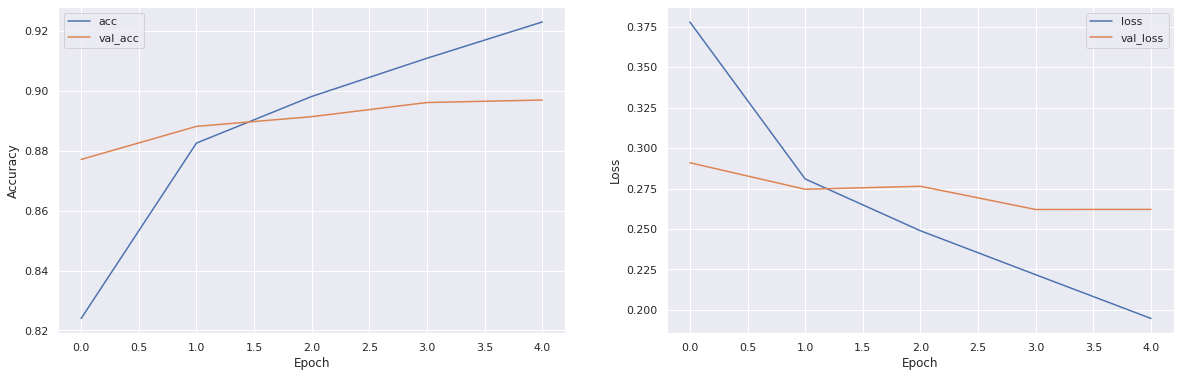

In [ ]:
sns.set(color_codes=True)

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(20, 6))
graph1 = fig.add_subplot(1, 2, 1)
graph2 = fig.add_subplot(1, 2, 2)

ax1 = sns.lineplot(data=acc, label='acc', ax=graph1)
sns.lineplot(data=val_acc, label='val_acc', ax=graph1)
ax2 = sns.lineplot(data=loss, label='loss', ax=graph2)
sns.lineplot(data=val_loss, label='val_loss', ax=graph2)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

plt.show()

### Evaluation

In [ ]:
# text_tokenize
test_inputs, test_labels = text_preprocessing(test_data, test_label)

100%|██████████| 24718/24718 [00:07<00:00, 3469.01it/s]


In [ ]:
model.load_weights(filepath=checkpoint_path + 'best_Kobert_weights.h5')

pred = model.predict(test_inputs)
pred = tf.argmax(pred, axis=1)

print(accuracy_score(pred, test_labels))

0.8982927421312404


### Save Model

In [ ]:
with open(checkpoint_path + 'model_koBERTfunction_v1.pkl', 'wb') as f:
  pickle.dump(dill.dumps(create_model), f)

## Service

In [ ]:
from IPython.display import clear_output 

!pip install transformers
!pip install tensorflow_addons
!pip install sentencepiece==0.1.96

!git clone https://github.com/monologg/KoBERT-Transformers.git 
!mv KoBERT-Transformers/kobert_transformers/tokenization_kobert.py /content 


clear_output()

In [ ]:
from transformers import BertTokenizerFast, TFBertModel
from tokenization_kobert import KoBertTokenizer 
import tensorflow as tf
import tensorflow_addons as tfa
import sentencepiece as spm 
import re
import numpy as np
import pickle
import dill

SEQ_LEN = 128
path = '/gdrive/MyDrive/Colab Notebooks/steam_reviews/saved_models/'

# tokenizer
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

# model
with open(path + 'model_koBERTfunction_v1.pkl', 'rb') as f:
  create_model = dill.loads(pickle.load(f))

model = create_model()
model.load_weights(filepath=path + 'best_Kobert_weights.h5')

def predict_sentiment(sentence, tokenizer, model):
  encoded_dict = tokenizer.encode_plus(text=re.sub('[^\s0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣]', '', sentence),
                                       padding='max_length', 
                                       truncation = True,
                                       max_length=SEQ_LEN)
  
  token_ids = np.array(encoded_dict['input_ids']).reshape(1, -1)
  token_masks = np.array(encoded_dict['attention_mask']).reshape(1, -1)
  token_segments = np.array(encoded_dict['token_type_ids']).reshape(1, -1)  

  return model.predict((token_ids, token_masks, token_segments))

In [ ]:
# input
new_sentence = input()

# view
prediction = predict_sentiment(new_sentence, tokenizer, model) # function -> API

predicted_probability = np.round(np.max(prediction) * 100, 2)
predicted_class = ['부정', '긍정'][np.argmax(prediction, axis=1)[0]]
print('{}% 확률로 {} 리뷰입니다.'.format(predicted_probability, predicted_class))

볼것도 없이 1점
99.78% 확률로 부정 리뷰입니다.
